# Model 2:

Batched Draupnir Model with latent tree


Model details:

|Flavor|Included or Not|
|:---------:|:-----:|
|Unaligned Sequences| |
|Latent Tree|×|
|Batched Input|×|




In [ ]:
leaf_seq_path = "/content/realign_MSA.fas"
ancestor_path = "/content/_pep_Unaligned_Internal_Nodes.FASTA"
tree_path = "/content/_True_Rooted_tree_node_labels.tre"

In [ ]:
! pip install pyro-ppl
! pip install Biopython

     |████████████████████████████████| 718 kB 4.9 MB/s 
     |████████████████████████████████| 2.3 MB 4.9 MB/s 


In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import math

from ASR import ASR

In [ ]:
batch_size = 128

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S, S_names, S_char = load_MSA_Data(leaf_seq_path, "cuda", AA_dict)

_, Anc_names, Anc_lengths, Anc_char = load_Unaligned_Data(ancestor_path, "cuda", AA_dict)
Anc_names[Anc_names.index("Node1 The root")] = "Node1"

In [ ]:
def get_true_tree_distances_including_ancestors(true_tree_path, S_names, ancestor_names):
    """
    Only work for simulation data
    Since the names of simulated ancestors are just numbers, Biopython will interpret them as "confidence" by default
    And there is no name/confidence for root

    """
    t = Phylo.read(true_tree_path, "newick")
    nodes = t.get_terminals() + t.get_nonterminals()
    mat = np.zeros([len(nodes), len(nodes)])
    names = S_names + ancestor_names

    for x, y in itertools.combinations(nodes, 2):
        v = t.distance(x, y)
        x_name = "Node" + str(x.confidence) if x.confidence is not None else "Node1" if x.name is None else x.name
        y_name = "Node" + str(y.confidence) if y.confidence is not None else "Node1" if y.name is None else y.name
        idx, idy = names.index(x_name), names.index(y_name)
        mat[idx][idy] = v
        mat[idy][idx] = v
    return mat

In [ ]:
# true_tree_distances_including_ancestors = get_true_tree_distances_including_ancestors(tree_path, S_names, Anc_names)
# true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

import pickle

# with open("matrix.txt", "wb") as f:
#     pickle.dump(true_tree_distances_including_ancestors, f)
with open("matrix.txt", "rb") as f:
    true_tree_distances_including_ancestors = pickle.load(f)
true_tree_distances = true_tree_distances_including_ancestors[:len(S_names), :len(S_names)]

In [ ]:
true_tree_distances_including_ancestors.shape, true_tree_distances.shape

((2047, 2047), (1024, 1024))

In [ ]:
pyro.clear_param_store()
vae = VAE(50, 24, S.shape[1])

In [ ]:
def per_param_callable(module_name, param_name):
    if param_name in ["tree_embed_loc", "tree_embed_len"]:
        return {"lr": 0.01, "clip_norm": 10}
    elif param_name in ["sigma_f_loc", "sigma_n_loc", "lambd_loc"]:
        return {"lr": 1e-6, "clip_norm": 10}
    else:   
        return {"lr": 0.001, "clip_norm": 10}
optimizer = pyro.optim.ClippedAdam(per_param_callable)
svi = SVI(vae.standard_asr_batched_model_latent_tree, vae.standard_asr_batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))

In [ ]:
ELBOs = []

Rec_Acc = []
Rec_Acc_remove_gap = []

In [ ]:
for b in tqdm(range(400)):
    indices = np.random.choice(S.shape[0], S.shape[0], False)
    elbos = []
    for batch in range(S.shape[0] // batch_size - 1):
      batch_idx = indices[batch * batch_size: batch * batch_size + batch_size]
      back_idx = indices[S.shape[0] // batch_size * batch_size - batch_size:]
      all_idx = np.concatenate([back_idx, batch_idx])
      elbo = svi.step(
              aligned_S=S[batch_idx],
              S_length=None,
              S_index=batch_idx,
              num_batch=S.shape[0] // batch_size - 1,
              aligned_S_back=S[back_idx],
              S_back_length=None,
              S_back_index=back_idx,
              num_instance=S.shape[0],
              tree_emb_dim=40
              )
      elbos.append(elbo)
    ELBOs.append(sum(elbos) / len(elbos))

  
    if b % 10 == 0:
        with torch.no_grad():
            # Rec ACC
            S_onehot = torch.zeros_like(S[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S[:, :, None], 1)
            S_onehot = S_onehot[:, :, :].float().cuda()
           
            Z_loc = vae.encoder(S_onehot, None)
            re_MSA = vae.decoder.forward(None, Z_loc, False)

            Rec_Acc_remove_gap.append(np.mean(reconstruction_accuracy(re_MSA, S_onehot, gap_index=23, remove_gap=True)))
            Rec_Acc.append(np.mean(reconstruction_accuracy(re_MSA, S_onehot, gap_index=23, remove_gap=False)))

    # if b == 120:
    #     def per_param_callable(module_name, param_name):
    #       if param_name in ["tree_embed_loc", "tree_embed_len"]:
    #           return {"lr": 1e-3, "clip_norm": 10}
    #       elif param_name in ["sigma_f_loc", "sigma_n_loc", "lambd_loc"]:
    #           return {"lr": 1e-6, "clip_norm": 10}
    #       else:   
    #           return {"lr": 0.001, "clip_norm": 10}
    #     optimizer = pyro.optim.ClippedAdam(per_param_callable)
    #     svi = SVI(vae.standard_asr_batched_model_latent_tree, vae.standard_asr_batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))


    if b == 120:
        def per_param_callable(module_name, param_name):
          if param_name in ["tree_embed_loc", "tree_embed_len"]:
              return {"lr": 1e-7, "clip_norm": 10}
          elif param_name in ["sigma_f_loc", "sigma_n_loc", "lambd_loc"]:
              return {"lr": 1e-4, "clip_norm": 10}
          else:   
              return {"lr": 0.001, "clip_norm": 10}
        optimizer = pyro.optim.ClippedAdam(per_param_callable)
        svi = SVI(vae.standard_asr_batched_model_latent_tree, vae.standard_asr_batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))


with torch.no_grad():

    # Distances Correlation
    latent_distance = 1 - torch.sum(Z_loc[None, :, :] * Z_loc[:, None, :], dim=-1) / torch.norm(Z_loc, p=2, dim=-1)[None, :] / torch.norm(Z_loc, p=2, dim=-1)[:, None]
    latent_distance = torch.norm(Z_loc[None, :, :] - Z_loc[:, None, :], dim=-1)
    latent_distance_upper = latent_distance[torch.triu_indices(S.shape[0], S.shape[0], 1)[0], torch.triu_indices(S.shape[0], S.shape[0], 1)[1]]
    real_distance_upper = true_tree_distances[torch.triu_indices(S.shape[0], S.shape[0], 1)[0], torch.triu_indices(S.shape[0], S.shape[0], 1)[1]]
    Spearmans = spearmanr(latent_distance_upper.cpu(), real_distance_upper)[0]
    Pearsonss = pearsonr(latent_distance_upper.cpu(), real_distance_upper)[0]

    # LCA ASR ACC
    sigma_f = pyro.param("sigma_f_loc")
    sigma_n = pyro.param("sigma_n_loc")
    lambd = pyro.param("lambd_loc")

    tree_emb_loc, tree_emb_len = pyro.param("tree_embed_loc"), pyro.param("tree_embed_len")
    tree_embedding = tree_emb_loc / tree_emb_loc.norm(dim=-1, keepdim=True) * tree_emb_len
    batch_distance = vae._get_D(tree_embedding, 0)
    tree = build_tree(batch_distance.cpu().numpy(), S_names)
    nj_tree_distances_including_ancestors, rec_ans_names = get_nj_tree_distance_including_ancestors(tree, S_names)
    nj_tree_distances = nj_tree_distances_including_ancestors[:len(S_names), :len(S_names)]


    cov = torch.from_numpy(nj_tree_distances_including_ancestors).to(vae.device).float()[np.newaxis, :, :].expand([vae.n_z, nj_tree_distances_including_ancestors.shape[0], nj_tree_distances_including_ancestors.shape[0]]) / lambd[:, np.newaxis, np.newaxis]
    cov = (torch.exp(-cov) * sigma_f[:, np.newaxis, np.newaxis] ** 2 + torch.eye(cov.shape[1], device=vae.device)[np.newaxis, :, :] * sigma_n[:, np.newaxis, np.newaxis] ** 2)

    cov_tips = cov[:, :len(S_names), :len(S_names)]
    cov_anc = cov[:, len(S_names):, len(S_names):]
    con_tips_anc = cov[:, len(S_names):, :len(S_names)]

    rec_anc = ASR(Z_loc, cov_tips, cov_anc, con_tips_anc, decoder=lambda x: vae.decoder(None, x, False))
    rec_anc = tensor2char(rec_anc, back_AA_dict)

    t = Phylo.read(tree_path, "newick")
    tips = t.get_terminals()
    tips = sorted(tips, key=lambda x: x.name)
    ground = []
    for i in range(len(tips)):
        for j in range(i+1, len(tips)):
            lca = t.common_ancestor(tips[i], tips[j])
            lca_name = "Node" + str(lca.confidence) if lca.confidence is not None else "Node1" 
            lca_index = Anc_names.index(lca_name)
            ground.append(Anc_char[lca_index])
    tips = tree.get_terminals()
    tips = sorted(tips, key=lambda x: x.name)
    predicts = []
    for i in tqdm(range(len(tips))):
        for j in range(i+1, len(tips)):
            lca = tree.common_ancestor(tips[i], tips[j])
            lca_name = lca.name
            lca_index = rec_ans_names.index(lca_name)
            predicts.append(rec_anc[lca_index])
    accs = asr_accuracy(ground, predicts)
    LCA_ASR_Acc = np.mean(accs)
    LCA_ASR_Acc_std = np.std(accs)
    LCA_ASR_Acc_max = np.max(accs)
    LCA_ASR_Acc_min = np.min(accs)

    # tree measure
    nj_tree_distances_upper = nj_tree_distances[torch.triu_indices(S.shape[0], S.shape[0], 1)[0], torch.triu_indices(S.shape[0], S.shape[0], 1)[1]]
    Spearmans_tree = spearmanr(nj_tree_distances_upper, real_distance_upper)[0]
    Pearsons_tree = pearsonr(nj_tree_distances_upper, real_distance_upper)[0]

    embed_distances_upper = batch_distance.cpu().numpy()[torch.triu_indices(S.shape[0], S.shape[0], 1)[0], torch.triu_indices(S.shape[0], S.shape[0], 1)[1]]
    Spearmans_dis = spearmanr(embed_distances_upper, real_distance_upper)[0]
    Pearsons_dis = pearsonr(embed_distances_upper, real_distance_upper)[0]

    


  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/distributions/dirichlet.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  torch.lgamma(self.concentration.sum(-1)) -
100%|██████████| 1024/1024 [07:40<00:00,  2.23it/s]


In [ ]:
Phylo.write(tree, "./tree_latent.tre", "newick")

1

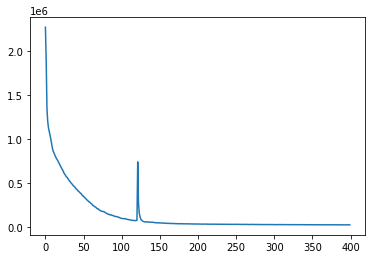

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)

0.9983992863370696


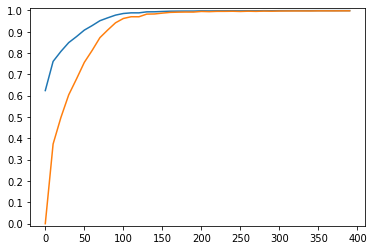

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.arange(len(Rec_Acc)) * 10, Rec_Acc)
plt.plot(np.arange(len(Rec_Acc_remove_gap)) * 10, Rec_Acc_remove_gap)
plt.ylim(-0.01, 1.01)
plt.yticks(np.arange(0, 1.01, 0.1))
print(max(Rec_Acc_remove_gap[1:]))

In [ ]:
print(Spearmans, Pearsonss)

0.5587328982517562 0.689490963506652


In [ ]:
LCA_ASR_Acc, LCA_ASR_Acc_std, LCA_ASR_Acc_max, LCA_ASR_Acc_min

(0.8012485289585981, 0.05320396942390226, 0.99079754601227, 0.5728155339805825)

In [ ]:
Spearmans_tree, Pearsons_tree, Spearmans_dis, Pearsons_dis

(0.557409911201676, 0.7070778767708815, 0.5044292653790763, 0.6935154120189122)

In [ ]:
pyro.param("sigma_f_loc"), pyro.param("sigma_n_loc"), pyro.param("lambd_loc")

(tensor([2.4168, 2.4156, 2.4147, 2.4159, 2.4163, 2.4136, 2.4171, 2.4176, 2.4178,
         2.4164, 2.4179, 2.4165, 2.4166, 2.4170, 2.4157, 2.4164, 2.4179, 2.4173,
         2.4137, 2.4137, 2.4156, 2.4137, 2.4171, 2.4170, 2.4158, 2.4161, 2.4148,
         2.4136, 2.4154, 2.4175, 2.4167, 2.4166, 2.4171, 2.4160, 2.4167, 2.4164,
         2.4169, 2.4148, 2.4177, 2.4166, 2.4157, 2.4172, 2.4163, 2.4167, 2.4156,
         2.4139, 2.4169, 2.4163, 2.4172, 2.4172], device='cuda:0',
        grad_fn=<AddBackward0>),
 tensor([0.1827, 0.1826, 0.1824, 0.1826, 0.1826, 0.1826, 0.1827, 0.1829, 0.1829,
         0.1826, 0.1829, 0.1828, 0.1826, 0.1827, 0.1825, 0.1826, 0.1829, 0.1828,
         0.1823, 0.1824, 0.1825, 0.1823, 0.1829, 0.1826, 0.1826, 0.1826, 0.1825,
         0.1823, 0.1825, 0.1829, 0.1827, 0.1828, 0.1826, 0.1826, 0.1827, 0.1828,
         0.1828, 0.1825, 0.1829, 0.1828, 0.1826, 0.1828, 0.1827, 0.1827, 0.1825,
         0.1824, 0.1827, 0.1827, 0.1828, 0.1828], device='cuda:0',
        grad_fn=<AddBac